# Load packages

In [1]:
import json
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# Function definitions

In [2]:
def amape(y_true, y_pred, accuracies):
    """ Adjusted MAPE
    """
    not_nan_mask = ~np.isnan(y_true)
    
    # calculate absolute error
    abs_error = (np.abs(y_true[not_nan_mask] - y_pred[not_nan_mask]))
    
    # calculate the percent error (replacing 0 with 1
    # in order to avoid divide-by-zero errors).
    pct_error = abs_error / np.maximum(1, y_true[not_nan_mask])
    
    # adjust error by count accuracies
    adj_error = pct_error / accuracies[not_nan_mask]
    
    # return the mean as a percentage
    return np.mean(adj_error)

In [3]:
def evolve_using_last(tainset, prediction_format, alpha):
    
    prediction = prediction_format.copy()
    
    last_value = tainset.fillna(method='ffill', axis = 1)[tainset.columns[-1]].fillna(value = 0.0)
    for col in prediction.columns:
        prediction.ix[:,col] = last_value
       
    for i in range(len(prediction)):
        fac = alpha[prediction.iloc[i].name[1]]
        prediction.iloc[i] = prediction.iloc[i]*fac
    
    return prediction

In [4]:
def evolve_using_last_v2(tainset, prediction_format):
    
    prediction = prediction_format.copy()
    
    last_value = tainset.fillna(method='ffill', axis = 1)[tainset.columns[-1]].fillna(value = 0.0)
    for col in prediction.columns:
        prediction.ix[:,col] = last_value
    
    return prediction

In [5]:
def evolve_using_rates(trainset, prediction_format, changerate, alpha, minvalue = 0):
    ''' possible tunnable parameters:   smooth factor
                                        minimum value (last valid?, fixed number?)
                                        both could be per penguin type
    '''
    
    firstyearrate = changerate.index[0]    
    prediction = pd.concat([trainset, prediction_format], axis = 1)
    
    for ix in trainset.index:
        penguin = ix[1]
        lastyear = trainset.ix[ix].last_valid_index()
        if lastyear == None:
            pass
        else:
            if lastyear < firstyearrate:
                lastvalue = trainset.ix[ix][lastyear]
                lastyear = firstyearrate

            else:
                lastvalue = trainset.ix[ix][lastyear]
                
            for year in range(lastyear+1, prediction_format.columns[-1]+1):
                fac = changerate.ix[year-1][penguin]*alpha[penguin]
                lastvalue = np.max([lastvalue*fac, minvalue])
                prediction.ix[ix, year] = lastvalue
            
    return prediction[prediction_format.columns]

In [6]:
def evolve_using_rates_v2(trainset, prediction_format, changerate, minvalue = 0):
    ''' possible tunnable parameters:   smooth factor
                                        minimum value (last valid?, fixed number?)
                                        both could be per penguin type
    '''
    
    firstyearrate = changerate.index[0]    
    prediction = pd.concat([trainset, prediction_format], axis = 1)
    
    for ix in trainset.index:
        penguin = ix[1]
        lastyear = trainset.ix[ix].last_valid_index()
        if lastyear == None:
            pass
        else:
            if lastyear < firstyearrate:
                lastvalue = trainset.ix[ix][lastyear]
                lastyear = firstyearrate

            else:
                lastvalue = trainset.ix[ix][lastyear]
                
            for year in range(lastyear+1, prediction_format.columns[-1]+1):
                fac = changerate.ix[year-1][penguin]                
                lastvalue = np.max([lastvalue*fac, minvalue])
                prediction.ix[ix, year] = lastvalue
            
    return prediction[prediction_format.columns]

In [7]:
def apply_alpha(df, alpha):
    ts = df.copy()
    for ix in ts.index:
        penguin = ix[1]
        ts.ix[ix] = ts.ix[ix]*alpha[penguin]
        
    return ts

In [8]:
def optimize_alphas(ts, ts_target, en_target, names, da = 0.05, alphamin = 0.05, alphamax = 2.):
    
    alpha = {names[0]: 1., 
             names[1]: 1., 
             names[2]: 1.}  

    alphai = np.linspace(alphamin, alphamax, (alphamax-alphamin)/da +1)
    
    score_alpha = pd.DataFrame(index = alphai, columns = names)

    for name in tqdm_notebook(names, leave = False):
        alpha_opt = alpha.copy()
        scores_name = []
        for ai in tqdm_notebook(alphai, leave = False):
            alpha_opt[name] = ai
            ts_predai = apply_alpha(ts, alpha_opt)
            scores_name.append(amape(ts_target.values, ts_predai.values, en_target.values))

        score_alpha[name] = scores_name

    dummy = score_alpha[score_alpha == score_alpha.min()]    
    alpha_opt = alpha.copy()
    for penguin in names:
        alpha_opt[penguin] = dummy[penguin].dropna().index[0]

    ts_opt = apply_alpha(ts, alpha_opt)
    score_opt = amape(ts_target.values, ts_opt.values, en_target.values)
    
    return alpha_opt, ts_opt, score_opt, score_alpha

# Load data

In [9]:
with open('../data/read_csv_kwargs.json', 'r') as fin:
    kwar = json.load(fin)
    
ts_nests = pd.read_csv('../data/training_set_nest_counts.csv', **kwar)
en_values = pd.read_csv('../data/training_set_e_n.csv',**kwar)   
sub_format = pd.read_csv('../data/submission_format.csv', **kwar)

ts_nests.columns = ts_nests.columns.astype(int)  
en_values.columns = en_values.columns.astype(int) 
sub_format.columns = sub_format.columns.astype(int) 

names = ts_nests.reset_index().common_name.unique()
colors = {names[0]:'red', names[1]:'blue', names[2]: 'green'}
print(colors)

actual_rates = pd.read_csv('submissions/rates/actual_rates.csv', index_col=0)

{'chinstrap penguin': 'blue', 'adelie penguin': 'red', 'gentoo penguin': 'green'}


## Naive and optimized last value

In [10]:
years = np.arange(2000, 2011)
duration = 3

sc_last = pd.DataFrame(index = years, columns= ['last', 'last_opt'] + list(names))
scores_last = []
scores_last_opt = []

sc_rates = pd.DataFrame(index = years, columns= ['actual_rates', 'actual_rates_opt'] + list(names))
scores_actual = []
scores_actual_opt = []

sc_rates2 = pd.DataFrame(index = years, columns= ['actual_rates', 'actual_rates_opt'] + list(names))
scores_actual2 = []
scores_actual_opt2 = []

In [11]:
for year in tqdm_notebook(years):
    ts_train = ts_nests[[x for x in ts_nests.columns if x <= year]]
    ts_target = ts_nests[[x for x in ts_nests.columns if x > year and x <= year +3]]
    en_target = en_values[[x for x in ts_nests.columns if x > year and x <= year +3]]

    pred_format = ts_target.copy()
    pred_format.ix[:,:] = np.zeros(pred_format.shape)

    ts_pred_last = evolve_using_last_v2(ts_train, pred_format)
    score_last = amape(ts_target.values, ts_pred_last.values, en_target.values)
    alpha_opt, ts_last_opt, score_last_opt, score_last_alpha = optimize_alphas(ts_pred_last, 
                                                             ts_target, 
                                                             en_target, 
                                                             names)
    scores_last.append(score_last)
    scores_last_opt.append(score_last_opt)
    
    ts_rates = evolve_using_rates_v2(ts_train, pred_format, actual_rates)
    score_rates = amape(ts_target.values, ts_rates.values, en_target.values)
    alpha_rates, ts_rates_opt, score_rates_opt, score_rates_alpha = optimize_alphas(ts_rates, 
                                                             ts_target, 
                                                             en_target, 
                                                             names)
    scores_actual.append(score_rates)
    scores_actual_opt.append(score_rates_opt)
    
    ts_rates2 = evolve_using_rates_v2(ts_train.fillna(method='ffill', axis = 1).fillna(value = 0.0), pred_format, actual_rates)
    score_rates2 = amape(ts_target.values, ts_rates2.values, en_target.values)
    alpha_rates2, ts_rates_opt2, score_rates_opt2, score_rates_alpha2 = optimize_alphas(ts_rates2, 
                                                             ts_target, 
                                                             en_target, 
                                                             names)    
    
    scores_actual2.append(score_rates2)
    scores_actual_opt2.append(score_rates_opt2)
    
    for name in names:
        sc_last.ix[year][name] = alpha_opt[name]
        sc_rates.ix[year][name] = alpha_rates[name]
        sc_rates2.ix[year][name] = alpha_rates2[name]
            
sc_last['last'] = scores_last
sc_last['last_opt'] = scores_last_opt

sc_rates['actual_rates'] = scores_actual
sc_rates['actual_rates_opt'] = scores_actual_opt

sc_rates2['actual_rates'] = scores_actual2
sc_rates2['actual_rates_opt'] = scores_actual_opt2

In [12]:
sc_last.to_csv('submissions/rates/AMAPE_last.csv')
sc_rates.to_csv('submissions/rates/AMAPE_rates.csv')
sc_rates2.to_csv('submissions/rates/AMAPE_rates2.csv')

(0, 40)

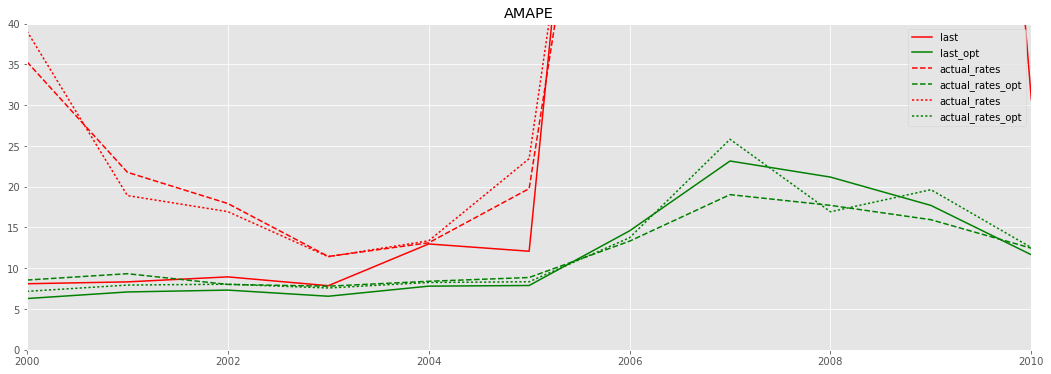

In [21]:
ax = sc_last[['last', 'last_opt']].plot(figsize = (18,6), style = '-', color = ['red', 'green'])
sc_rates[['actual_rates', 'actual_rates_opt']].plot(ax = ax, style = '--',color = ['red', 'green'])
sc_rates2[['actual_rates', 'actual_rates_opt']].plot(ax = ax, style = ':', color = ['red', 'green'])
plt.legend()
plt.title('AMAPE')
plt.ylim(0, 40)

In [20]:
ax = sc_last[list(names)].plot(figsize = (18,6), style = '-', color = [colors[penguin] for penguin in names])
sc_rates[list(names)].plot(ax = ax, marker = 'o', style = '--', color = [colors[penguin] for penguin in names])
sc_rates2[list(names)].plot(ax = ax, marker = 'd', style = ':', color = [colors[penguin] for penguin in names])
plt.legend()
plt.title('alphas')

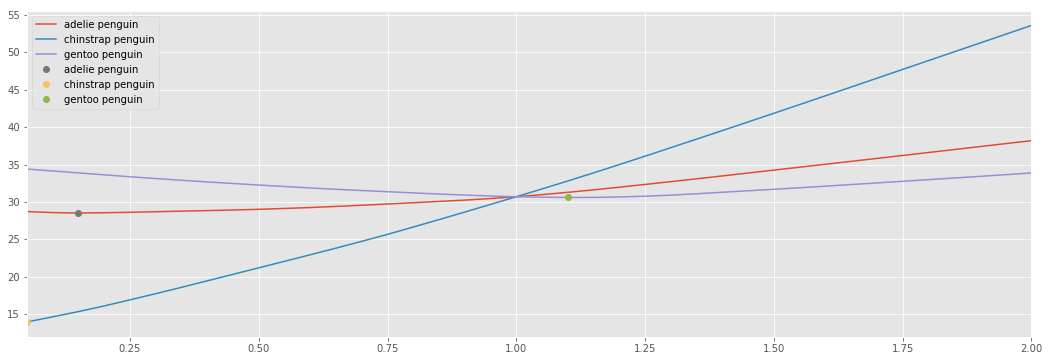

In [39]:
ax = score_last_alpha.plot(figsize = (18,6))
score_last_alpha[score_last_alpha==score_last_alpha.min()].plot(style = 'o', ax = ax)

In [11]:
for year in tqdm_notebook(years):
    ts_train = ts_nests[[x for x in ts_nests.columns if x <= year]]
    ts_target = ts_nests[[x for x in ts_nests.columns if x > year and x <= year +3]]
    en_target = en_values[[x for x in ts_nests.columns if x > year and x <= year +3]]

    pred_format = ts_target.copy()
    pred_format.ix[:,:] = np.zeros(pred_format.shape)

In [37]:
last = ts_train.ffill(axis = 1)[ts_train.columns[-1]]

In [50]:
dummy = ts_target[2013]/last

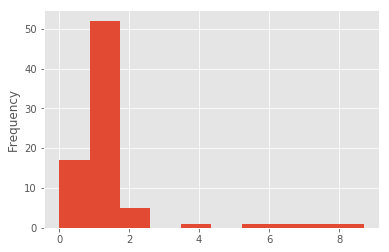

In [51]:
dummy[dummy < np.inf].plot(kind = 'hist')

In [52]:
dummy.reset_index().groupby('common_name').mean()

0
common_name                
adelie penguin     1.400487
chinstrap penguin  1.337802
gentoo penguin     1.535018

In [42]:
actual_rates

adelie penguin  chinstrap penguin  gentoo penguin
1979        0.325671           4.154066        1.107642
1980        4.911696           0.096490        0.822362
1981        0.257008           1.467010        0.309678
1982        2.813295           4.766758        1.329330
1983        0.561329           0.125757        1.843450
...              ...                ...             ...
2008        0.785469           0.121416        1.240485
2009        1.495051           0.920375        0.709218
2010        0.952343           4.623626        1.429796
2011        0.582620           0.159613        0.770437
2012        3.737609           1.064484        1.201896

[34 rows x 3 columns]

In [26]:
ts_target[2012]

site_id  common_name      
ACUN     adelie penguin          NaN
         chinstrap penguin       NaN
ADAM     adelie penguin          NaN
ADAR     adelie penguin          NaN
AILS     chinstrap penguin       NaN
                               ...  
YALO     gentoo penguin         28.0
YANK     gentoo penguin       4803.0
YOUN     adelie penguin          NaN
ZAWA     chinstrap penguin       NaN
ZIGZ     chinstrap penguin       NaN
Name: 2012, dtype: float64

In [28]:
last

site_id  common_name      
ACUN     adelie penguin         3079.0
         chinstrap penguin      4000.0
ADAM     adelie penguin           76.0
ADAR     adelie penguin       338231.0
AILS     chinstrap penguin      6000.0
                                ...   
YALO     gentoo penguin           23.0
YANK     gentoo penguin         4817.0
YOUN     adelie penguin            0.0
ZAWA     chinstrap penguin       450.0
ZIGZ     chinstrap penguin      1000.0
Name: 2010, dtype: float64